In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay tqdm

In [2]:
%%capture
from pyvirtualdisplay import Display
vistual_display = Display(visible=0, size=(1400, 900))
vistual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# 认识openal_gym
一个用于做reinforcement learning的库

In [3]:
%%capture
import gym
env = gym.make('LunarLander-v2')

In [4]:
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (8,), float32)
Discrete(4)


In [5]:
initial_state = env.reset()
print(initial_state)

[ 0.00242996  1.4070088   0.24610765 -0.17383528 -0.00280886 -0.05574699
  0.          0.        ]


In [6]:
random_action = env.action_space.sample()
print(random_action)

3


In [7]:
obvervation, reward, done, info = env.step(random_action)

In [8]:
print(done)

False


In [9]:
print(reward)

-2.1986107729064472


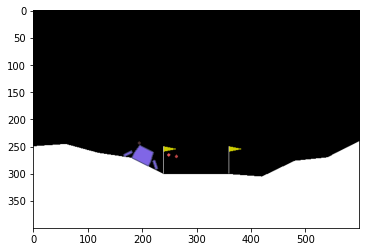

In [10]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# reinforcement learning

In [11]:
class PolicyGradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)
    
    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [12]:
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        # 在一般的DL中，目标是最小化loss。但在RL中，我们希望得到的分数越大越好，所以要对min加上负号
        # 也就是将gradient descend变成gradient ascend。注意log_probs本身是负无穷到0之间的单增函数
        loss = (-log_probs * rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        # 经过network后，action_prob是每种动作被执行的概率prob
        action_prob = self.network(torch.FloatTensor(state))
        # 在知道每种action被执行的概率基础上，我们采用Categorical进行sample，以保证所有的action都有机会被sample到
        # 虽然每种动作被sample的概率不同
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        # 将被sample出的action所对应的prob转化为log(prob)的形式
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [13]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

train

In [ ]:
agent.network.train()
EPISODE_PER_BATCH = 5
NUM_BATCH = 4000

avg_total_rewards, avg_final_rewards = [], []
prg_bar = tqdm(range(NUM_BATCH))

for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward, total_step = 0, 0
        while True:
            action, log_prob = agent.sample(state) # 返回的是经过network后要执行的action和所对应的log(prob)
            # 和环境互动，执行action，得到新的state，reward和整个互动是否结束的标志
            next_state, reward, done, _ = env.step(action) 
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done: # 如果整轮互动结束
                final_rewards.append(reward) # 记录最后的得分
                total_rewards.append(total_reward) # 记录整个过程的得分
                rewards.append(np.full(total_step, total_reward)) # 将整个过程的得分copy到每一个step中
                break

    avg_total_reward = sum(total_rewards) / len(total_rewards) # len(total_rewards)=5
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f'total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}')

    # 更新网络参数
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

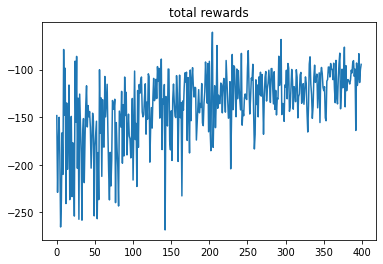

In [17]:
# 这里描述的是reward，也就是agent得到的分数，应该是随着训练的进行越来越大
plt.plot(avg_total_rewards)
plt.title('total rewards')
plt.show()

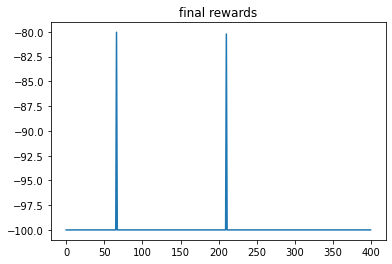

In [18]:
# final reward描述了最后小飞艇是否成功降落在平面
# REWARD RULE:
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. 
# If lander moves away from landing pad it loses reward back. 
# Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
# Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.
plt.plot(avg_final_rewards)
plt.title('final rewards')
plt.show()

test


In [ ]:
agent.network.eval()
state = env.reset()
img = plt.imshow(env.render(model='rgb_array'))
total_reward = 0
done=False

while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward
    img.set_data(env.render(model='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)